In [2]:
# Our standard imports :)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=False)

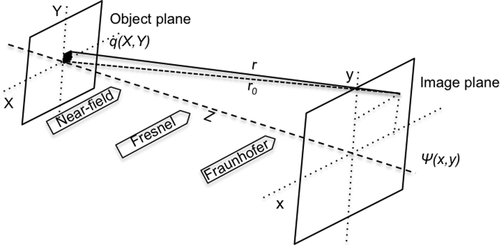

### Diffraction as a Fourier Transform

(sketch taken from Xiong et al. 2014)

Now we are going to try to solve diffraction problems using Fourier transform form multiple 1D and 2D setups.

In 1D we have the following situation:

### $E(\theta) = \int_{-\infty}^{\infty} A(x) e^{-ik\theta x} dx$

original Fourier Transform looks like:

### $E(k_x) = \int_{-\infty}^{\infty} A(x) e^{-i k_x dx} dx$

while in 2D, the integral extends over both $x$ and $y$:

### $E(\phi, \theta) = \int A(x,y) e^{-ik(\phi x + \theta y)} dx dy$

This is actually Fourier transform in 1D and 2D, but we will first try to just solve the integral manually, using some basic numerical integration.

In [3]:
# Let's first to the analytical, to be able to check:

b = 0.1E-3 # width of the slit


llambda = 500E-9 # our favorite 500 nm


theta = np.linspace(-3,3,1000) # angle in degrees, avoid zero on purpose

k = 2*np.pi/llambda 

beta = k * b * theta * np.pi/180.0 / 2.

I_analytical = (np.sin(beta)/beta)**2.0 # Diffraction pattern. That is: Distribution of the irradiance with angle

In [3]:
%%time
# And now numerically solve integral for 1D diffraction from up there: 

# we are integrating over the aperture: 
x_grid = np.linspace(-b/2,b/2,1001)

step = x_grid[1] - x_grid[0]

E_p = np.zeros(len(theta))
E_p = E_p.astype("complex")

for t in range(0,len(theta)):
    
    function_to_integrate = np.exp(-1j*k*theta[t]*np.pi/180.0*x_grid)
    
    integral = np.sum(function_to_integrate)*step
    
    E_p[t] = integral
    
I_numerical = np.abs(E_p)**2.0

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 140 ms


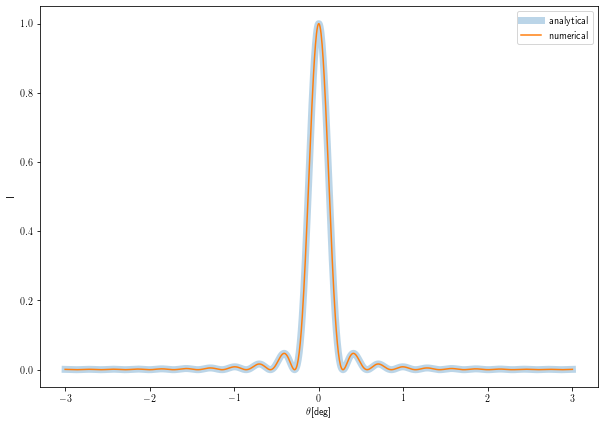

In [6]:
plt.figure(figsize=[10,7])
plt.plot(theta,I_analytical/np.max(I_analytical),alpha=0.3, linewidth = 7,label='analytical')
plt.plot(theta,I_numerical/np.max(I_numerical),label='numerical')
plt.xlabel("$\\theta $[deg]")
plt.ylabel("I")
plt.legend()

### Wow, this actually works quite well. But in 2D it would be quite tedious and numerically demanding.

Text(0, 0.5, 'Aperture')

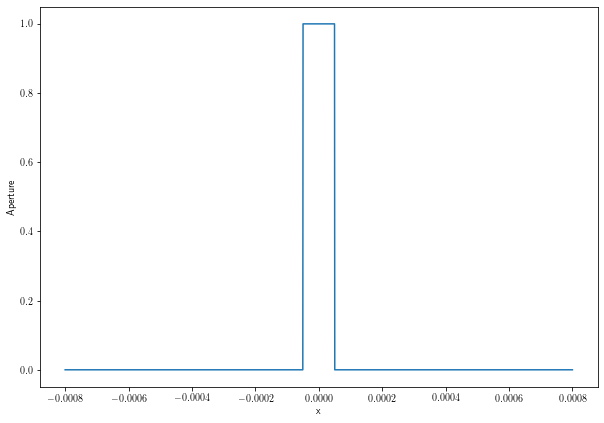

In [17]:
# Let's do the same using Fourier Transform:

N = 2048
x = np.linspace(-8*b,8*b,N) # Fourier transform likes powers of 2
A = np.zeros(N) # Aperture
A[:] = 1.0
A[np.where(x<-b/2)] = 0.0
A[np.where(x>b/2)]  = 0.0

plt.figure(figsize=[10,7])
plt.plot(x,A)
plt.xlabel("x")
plt.ylabel("Aperture")

In [18]:
%%time
# Now let's do that fourier transform:

E_p = np.fft.fft(A)

# This brings us our new coordinate:
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi

inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)

I_p = np.abs(E_p)**2.0

CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.04 ms


Text(0, 0.5, 'Irradiance')

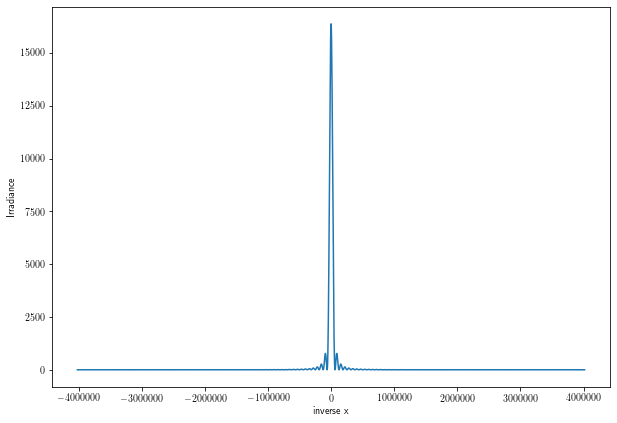

In [19]:
# let's plot:
plt.figure(figsize=[10,7])
plt.plot(inv_x,I_p)
plt.xlabel("inverse x")
plt.ylabel("Irradiance")

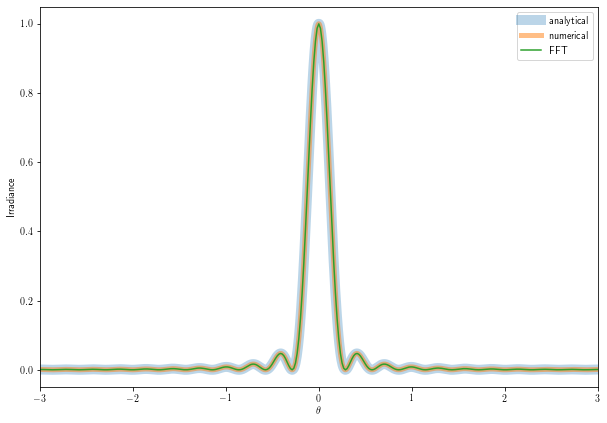

In [20]:
# THis does not make much sense, right? Because we are using inverse x. 

# inverse_x is actually k*theta
theta_fft = inv_x / k

# let's plot:
plt.figure(figsize=[10,7])
plt.plot(theta,I_analytical/np.max(I_analytical),alpha=0.3, linewidth = 10,label='analytical')
plt.plot(theta,I_numerical/np.max(I_numerical),alpha=0.5, linewidth = 5, label='numerical')
plt.plot(theta_fft*180.0/np.pi,I_p/np.max(I_p),label='FFT')
plt.xlabel("$\\theta$")
plt.ylabel("Irradiance")
plt.xlim([-3,3])
plt.legend()

The resolution is not as great, but that is the function, and it is insanely fast! (Compared to doing it by hand). 
Let's do a few different ones:

### Two slits:

Text(0, 0.5, 'Aperture')

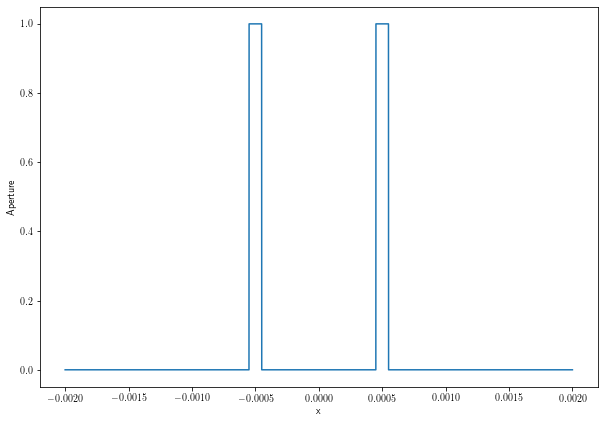

In [21]:
N = 4096
d = 1E-3
b = 0.1E-3
x = np.linspace(-2*d,2*d,N) # Fourier transform likes powers of 2
A1 = np.zeros(N) # Aperture
A1[:] = 1.0
A1[np.where(x<-d/2-b/2)] = 0.0
A1[np.where(x>d/2+b/2)]  = 0.0
A2 = np.zeros(N) # Aperture
A2[:] = 1.0
A2[np.where(x<-d/2+b/2)] = 0.0
A2[np.where(x>d/2-b/2)]  = 0.0
A = A1-A2

plt.figure(figsize=[10,7])
plt.plot(x,A)
plt.xlabel("x")
plt.ylabel("Aperture")

CPU times: user 25.4 ms, sys: 3.89 ms, total: 29.3 ms
Wall time: 29.7 ms


(-3, 3)

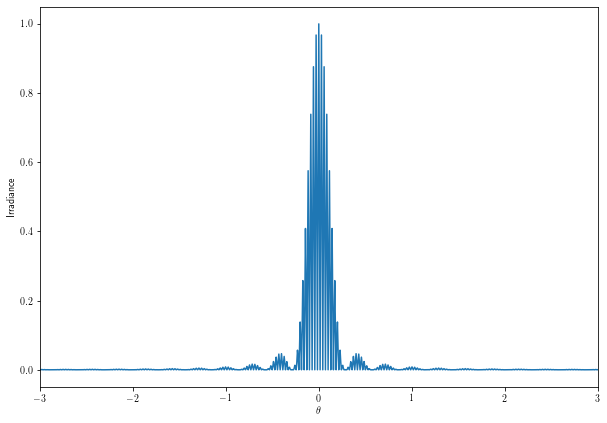

In [22]:
%%time
# Now let's do that fourier transform:

E_p = np.fft.fft(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi

inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
theta_fft = inv_x / k

# let's plot:
plt.figure(figsize=[10,7])
plt.plot(theta_fft*180.0/np.pi,I_p/np.max(I_p))
plt.xlabel("$\\theta$")
plt.ylabel("Irradiance")
plt.xlim([-3,3])

Text(0, 0.5, 'Aperture')

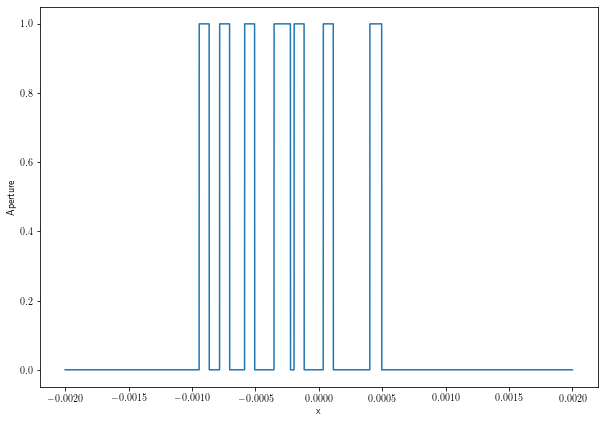

In [23]:
# Wow, looks good! 

# The advantage is, of course, that now we can calculate the diffraction pattern of any kind of slits
# positions, distributions, etc:

N = 8192
d = 1E-3
b = 0.04E-3
x = np.linspace(-2*d,2*d,N) # Fourier transform likes powers of 2
step = x[1] - x[0]

centers = np.random.randint(N/8,5*N/8,10)
width = int(b/step)
A = np.zeros(N)
for i in range(0,10):
    A[centers[i]-width:centers[i]+width] = 1.0
    
plt.figure(figsize=[10,7])
plt.plot(x,A)
plt.xlabel("x")
plt.ylabel("Aperture")

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 94.8 ms


(-1, 1)

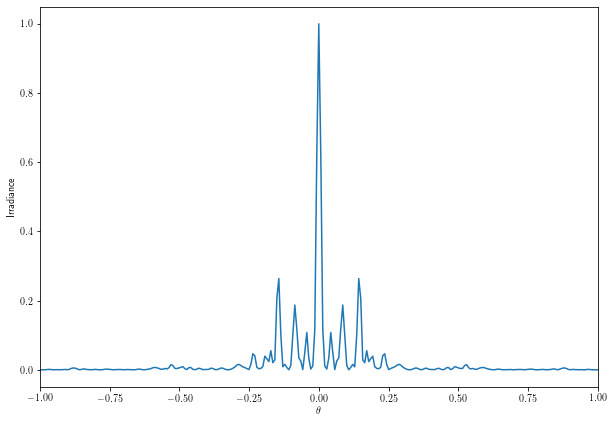

In [24]:
%%time
# Now let's do that fourier transform:

E_p = np.fft.fft(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi

inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
theta_fft = inv_x / k

# let's plot:
plt.figure(figsize=[10,7])
plt.plot(theta_fft*180.0/np.pi,I_p/np.max(I_p))
plt.xlabel("$\\theta$")
plt.ylabel("Irradiance")
plt.xlim([-1,1])

## Fourier transformation in 2D!

In [25]:
R = 5E-3 # radius of the aperture, say human eye
N = 4096
x = np.linspace(-8*R,8*R,N)
y = np.linspace(-8*R,8*R,N)
A = np.zeros([N,N])
A[:,:] = 1.0
out = np.where(x[:,None]**2.0 + y[None,:]**2.0 > R**2.0) 
A[out] = 0.0

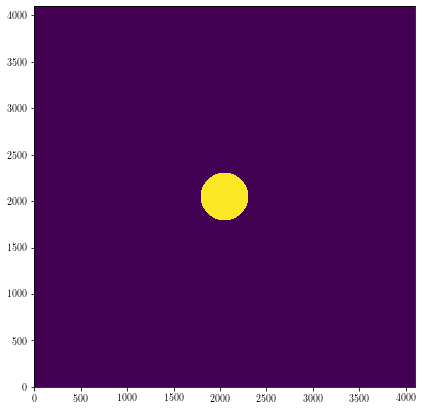

In [14]:
plt.figure(figsize=[10,7])
plt.imshow(A,origin='lower')

In [27]:
%%time
E_p = np.fft.fft2(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi
inv_y = np.fft.fftfreq(x.shape[-1])
inv_y /= (x[1]-x[0])/2/np.pi


inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
phi_fft = inv_x / k
theta_fft = inv_y/k


CPU times: user 1.45 s, sys: 308 ms, total: 1.76 s
Wall time: 591 ms


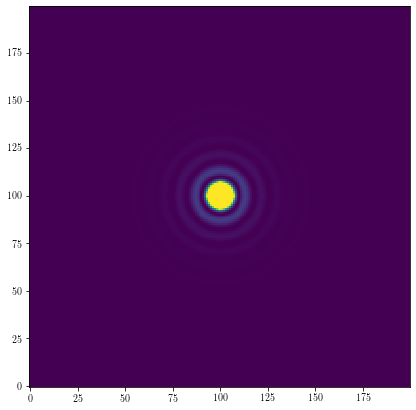

In [28]:
center = N//2
plt.figure(figsize=[10,7])
plt.imshow(I_p[center-100:center+100,center-100:center+100]/np.max(I_p),origin='lower',vmax=0.1)

# This is good old Airy disk! :)

$(x^2 + y^2 - 1) ^3 - x^2y^3 = 0$ This is a heart, actually

In [29]:
def heart(x,y):
    return ((x**2.0 + y**2.0 - 1.0)**3.0 - x**2.0*y**3.0)

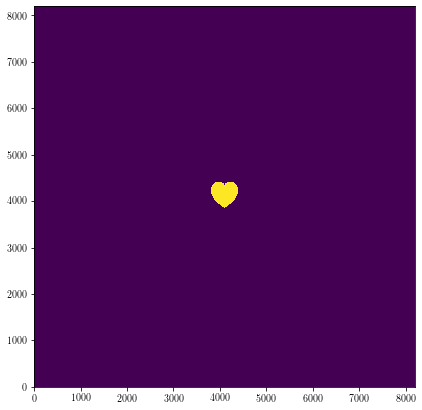

In [30]:
N = 8192
x = np.linspace(-16,16,N)
y = np.linspace(-16,16,N)
A = np.zeros([N,N])
A[:,:] = 1.0
out = np.where(heart(x[:,None],y[None,:]) > 0) 
A[out] = 0.0
plt.figure(figsize=[10,7])
plt.imshow(A.T,origin='lower')

In [33]:
E_p = np.fft.fft2(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi
inv_y = np.fft.fftfreq(x.shape[-1])
inv_y /= (x[1]-x[0])/2/np.pi


inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
phi_fft = inv_x / k
theta_fft = inv_y/k

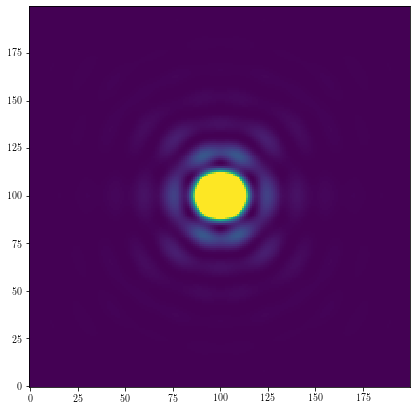

In [34]:
center = N//2
span = 100
plt.figure(figsize=[10,7])
plt.imshow((I_p[center-span:center+span,center-span:center+span]/np.max(I_p)),origin='lower',vmax=0.1)

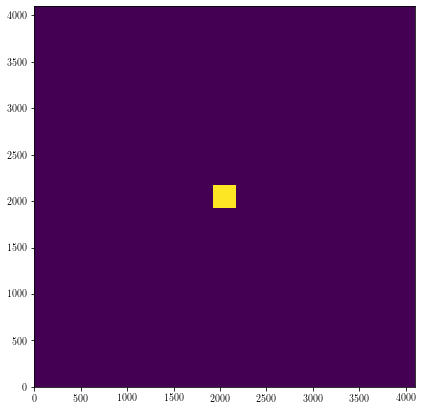

In [26]:
# Square
N = 4096
a=2
x = np.linspace(-16,16,N)
y = np.linspace(-16,16,N)
A = np.zeros([N,N])
A[:,:] = 1.0

A[:,np.where(np.abs(y)>a/2)] = 0
A[np.where(np.abs(x)>a/2),:] = 0

plt.figure(figsize=[10,7])
plt.imshow(A.T,origin='lower')

In [27]:
%%time
E_p = np.fft.fft2(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi
inv_y = np.fft.fftfreq(x.shape[-1])
inv_y /= (x[1]-x[0])/2/np.pi


inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
phi_fft = inv_x / k
theta_fft = inv_y/k

CPU times: user 799 ms, sys: 120 ms, total: 919 ms
Wall time: 441 ms


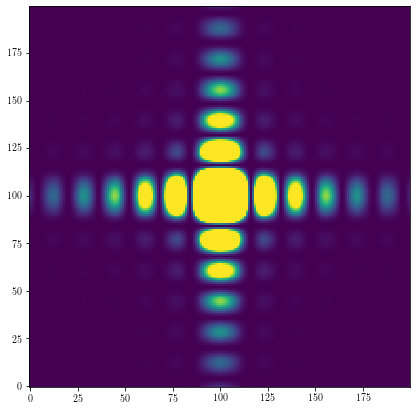

In [28]:
center = N//2
span = 100
plt.figure(figsize=[10,7])
plt.imshow((I_p[center-span:center+span,center-span:center+span]/np.max(I_p)),origin='lower',vmax=0.01)

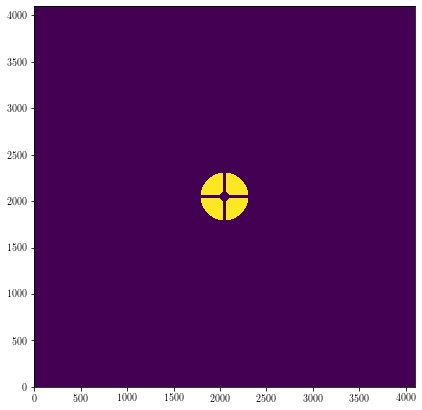

In [35]:
# Telescope, with some obstructions in the place:
R = 0.1 # radius of the aperture, say a telescope
N = 4096
x = np.linspace(-8*R,8*R,N)
y = np.linspace(-8*R,8*R,N)
A = np.zeros([N,N])
A[:,:] = 1.0
out = np.where(x[:,None]**2.0 + y[None,:]**2.0 > R**2.0) 
A[out] = 0.0
A[:,np.where(np.abs(y)<0.005)] = 0.0
A[np.where(np.abs(x)<0.005),:] = 0.0


inside = np.where(x[:,None]**2.0 + y[None,:]**2.0 < (0.2*R)**2.0)
A[inside] = 0.0

plt.figure(figsize=[10,7])
plt.imshow(A.T,origin='lower')

In [36]:
%%time
E_p = np.fft.fft2(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi
inv_y = np.fft.fftfreq(x.shape[-1])
inv_y /= (x[1]-x[0])/2/np.pi


inv_x = np.fft.fftshift(inv_x)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
phi_fft = inv_x / k
theta_fft = inv_y/k

CPU times: user 1.53 s, sys: 211 ms, total: 1.74 s
Wall time: 710 ms


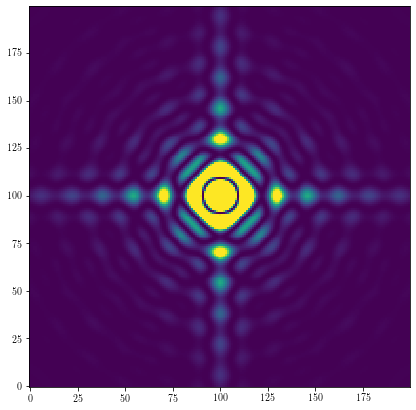

In [37]:
center = N//2
span = 100
plt.figure(figsize=[10,7])
plt.imshow((I_p[center-span:center+span,center-span:center+span]/np.max(I_p)),origin='lower',vmax=0.01)